In [1]:
# Data manipulation and numerical operations
import pandas as pd
import numpy as np
import re
import string
import warnings
import os
warnings.filterwarnings('ignore')

# Text preprocessing and feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                           confusion_matrix, classification_report, roc_auc_score, 
                           precision_recall_curve, roc_curve)

# Class imbalance handling
from sklearn.utils.class_weight import compute_class_weight

# Install and import imbalanced-learn
try:
    from imblearn.over_sampling import SMOTE, RandomOverSampler
    from imblearn.under_sampling import RandomUnderSampler
    from imblearn.combine import SMOTETomek
    print("✅ imbalanced-learn imported successfully!")
except ImportError:
    print("❌ imbalanced-learn not found. Installing...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "imbalanced-learn"])
    
    # Try importing again
    from imblearn.over_sampling import SMOTE, RandomOverSampler
    from imblearn.under_sampling import RandomUnderSampler
    from imblearn.combine import SMOTETomek
    print("✅ imbalanced-learn installed and imported!")

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Jupyter notebook specific settings
%matplotlib inline
plt.style.use('default')
sns.set_palette("husl")

# Set random seed for reproducibility
np.random.seed(42)

print("✅ Step 1 Complete: All libraries imported successfully!")
print("🎯 Ready for Kaggle dataset neural network implementation!")


✅ imbalanced-learn imported successfully!
✅ Step 1 Complete: All libraries imported successfully!
🎯 Ready for Kaggle dataset neural network implementation!


In [3]:
def load_kaggle_dataset(file_path='fake_job_postings.csv'):
    """Load the real Kaggle fake job postings dataset"""
    
    print("🔄 Step 2: Loading real Kaggle dataset...")
    
    # Check if file exists
    if not os.path.exists(file_path):
        print("❌ Dataset file not found!")
        print("📥 Please download the dataset from:")
        print("   https://www.kaggle.com/datasets/shivamb/real-or-fake-fake-jobposting-prediction")
        print("   Save it as 'fake_job_postings.csv' in your working directory")
        return None
    
    try:
        # Try different encodings for the Kaggle dataset
        for encoding in ['utf-8', 'latin-1', 'cp1252']:
            try:
                df = pd.read_csv(file_path, encoding=encoding)
                print(f"✅ Kaggle dataset loaded with {encoding} encoding")
                break
            except UnicodeDecodeError:
                continue
        else:
            raise ValueError("Could not decode file with any encoding")
        
        print(f"📊 Dataset shape: {df.shape}")
        
        # Validate this is the real Kaggle dataset
        expected_size = 17880  # Real Kaggle dataset size
        if len(df) == expected_size:
            print(f"✅ Confirmed: Real Kaggle dataset ({expected_size} samples)")
        else:
            print(f"⚠️  Dataset size ({len(df)}) doesn't match expected Kaggle size ({expected_size})")
        
        print(f"📋 Columns: {list(df.columns)}")
        
        # Validate required columns for Kaggle dataset
        required_cols = ['fraudulent']
        if 'fraudulent' not in df.columns:
            raise ValueError("Missing required 'fraudulent' column")
        
        # Check class distribution
        class_dist = df['fraudulent'].value_counts().sort_index()
        print(f"\n🎯 Real Kaggle Dataset Class Distribution:")
        print(f"   Real jobs (0): {class_dist[0]:,} ({class_dist[0]/len(df)*100:.1f}%)")
        print(f"   Fake jobs (1): {class_dist[1]:,} ({class_dist[1]/len(df)*100:.1f}%)")
        
        # Calculate imbalance ratio
        imbalance_ratio = class_dist[0] / class_dist[1]
        print(f"   Imbalance ratio: {imbalance_ratio:.2f}:1")
        
        # Check for missing values in key columns
        key_columns = ['title', 'description', 'company_profile', 'requirements']
        missing_info = df[key_columns].isnull().sum()
        
        print(f"\n❓ Missing values in key columns:")
        for col in key_columns:
            if col in df.columns:
                missing_count = missing_info[col] if col in missing_info else 0
                print(f"   {col}: {missing_count:,} ({missing_count/len(df)*100:.1f}%)")
        
        print("✅ Step 2 Complete: Real Kaggle dataset loaded successfully!")
        return df
        
    except Exception as e:
        print(f"❌ Error loading dataset: {str(e)}")
        return None

# Load the real Kaggle dataset
df = load_kaggle_dataset()

if df is not None:
    print(f"\n🔍 Sample of the Kaggle dataset:")
    display(df.head())
    
    print(f"\n📊 Kaggle Dataset Info:")
    print(f"   Shape: {df.shape}")
    print(f"   Columns: {len(df.columns)}")
    print(f"   Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
    
    # Show column details
    print(f"\n📋 Column Details:")
    for col in df.columns:
        dtype = df[col].dtype
        non_null = df[col].count()
        print(f"   {col}: {dtype}, {non_null:,} non-null")
else:
    print("❌ Cannot proceed without the real Kaggle dataset")


🔄 Step 2: Loading real Kaggle dataset...
✅ Kaggle dataset loaded with utf-8 encoding
📊 Dataset shape: (17880, 18)
✅ Confirmed: Real Kaggle dataset (17880 samples)
📋 Columns: ['job_id', 'title', 'location', 'department', 'salary_range', 'company_profile', 'description', 'requirements', 'benefits', 'telecommuting', 'has_company_logo', 'has_questions', 'employment_type', 'required_experience', 'required_education', 'industry', 'function', 'fraudulent']

🎯 Real Kaggle Dataset Class Distribution:
   Real jobs (0): 17,014 (95.2%)
   Fake jobs (1): 866 (4.8%)
   Imbalance ratio: 19.65:1

❓ Missing values in key columns:
   title: 0 (0.0%)
   description: 1 (0.0%)
   company_profile: 3,308 (18.5%)
   requirements: 2,696 (15.1%)
✅ Step 2 Complete: Real Kaggle dataset loaded successfully!

🔍 Sample of the Kaggle dataset:


,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0



📊 Kaggle Dataset Info:
   Shape: (17880, 18)
   Columns: 18
   Memory usage: 81.1 MB

📋 Column Details:
   job_id: int64, 17,880 non-null
   title: object, 17,880 non-null
   location: object, 17,534 non-null
   department: object, 6,333 non-null
   salary_range: object, 2,868 non-null
   company_profile: object, 14,572 non-null
   description: object, 17,879 non-null
   requirements: object, 15,184 non-null
   benefits: object, 10,668 non-null
   telecommuting: int64, 17,880 non-null
   has_company_logo: int64, 17,880 non-null
   has_questions: int64, 17,880 non-null
   employment_type: object, 14,409 non-null
   required_experience: object, 10,830 non-null
   required_education: object, 9,775 non-null
   industry: object, 12,977 non-null
   function: object, 11,425 non-null
   fraudulent: int64, 17,880 non-null


🔄 Step 3: Exploring real Kaggle dataset...


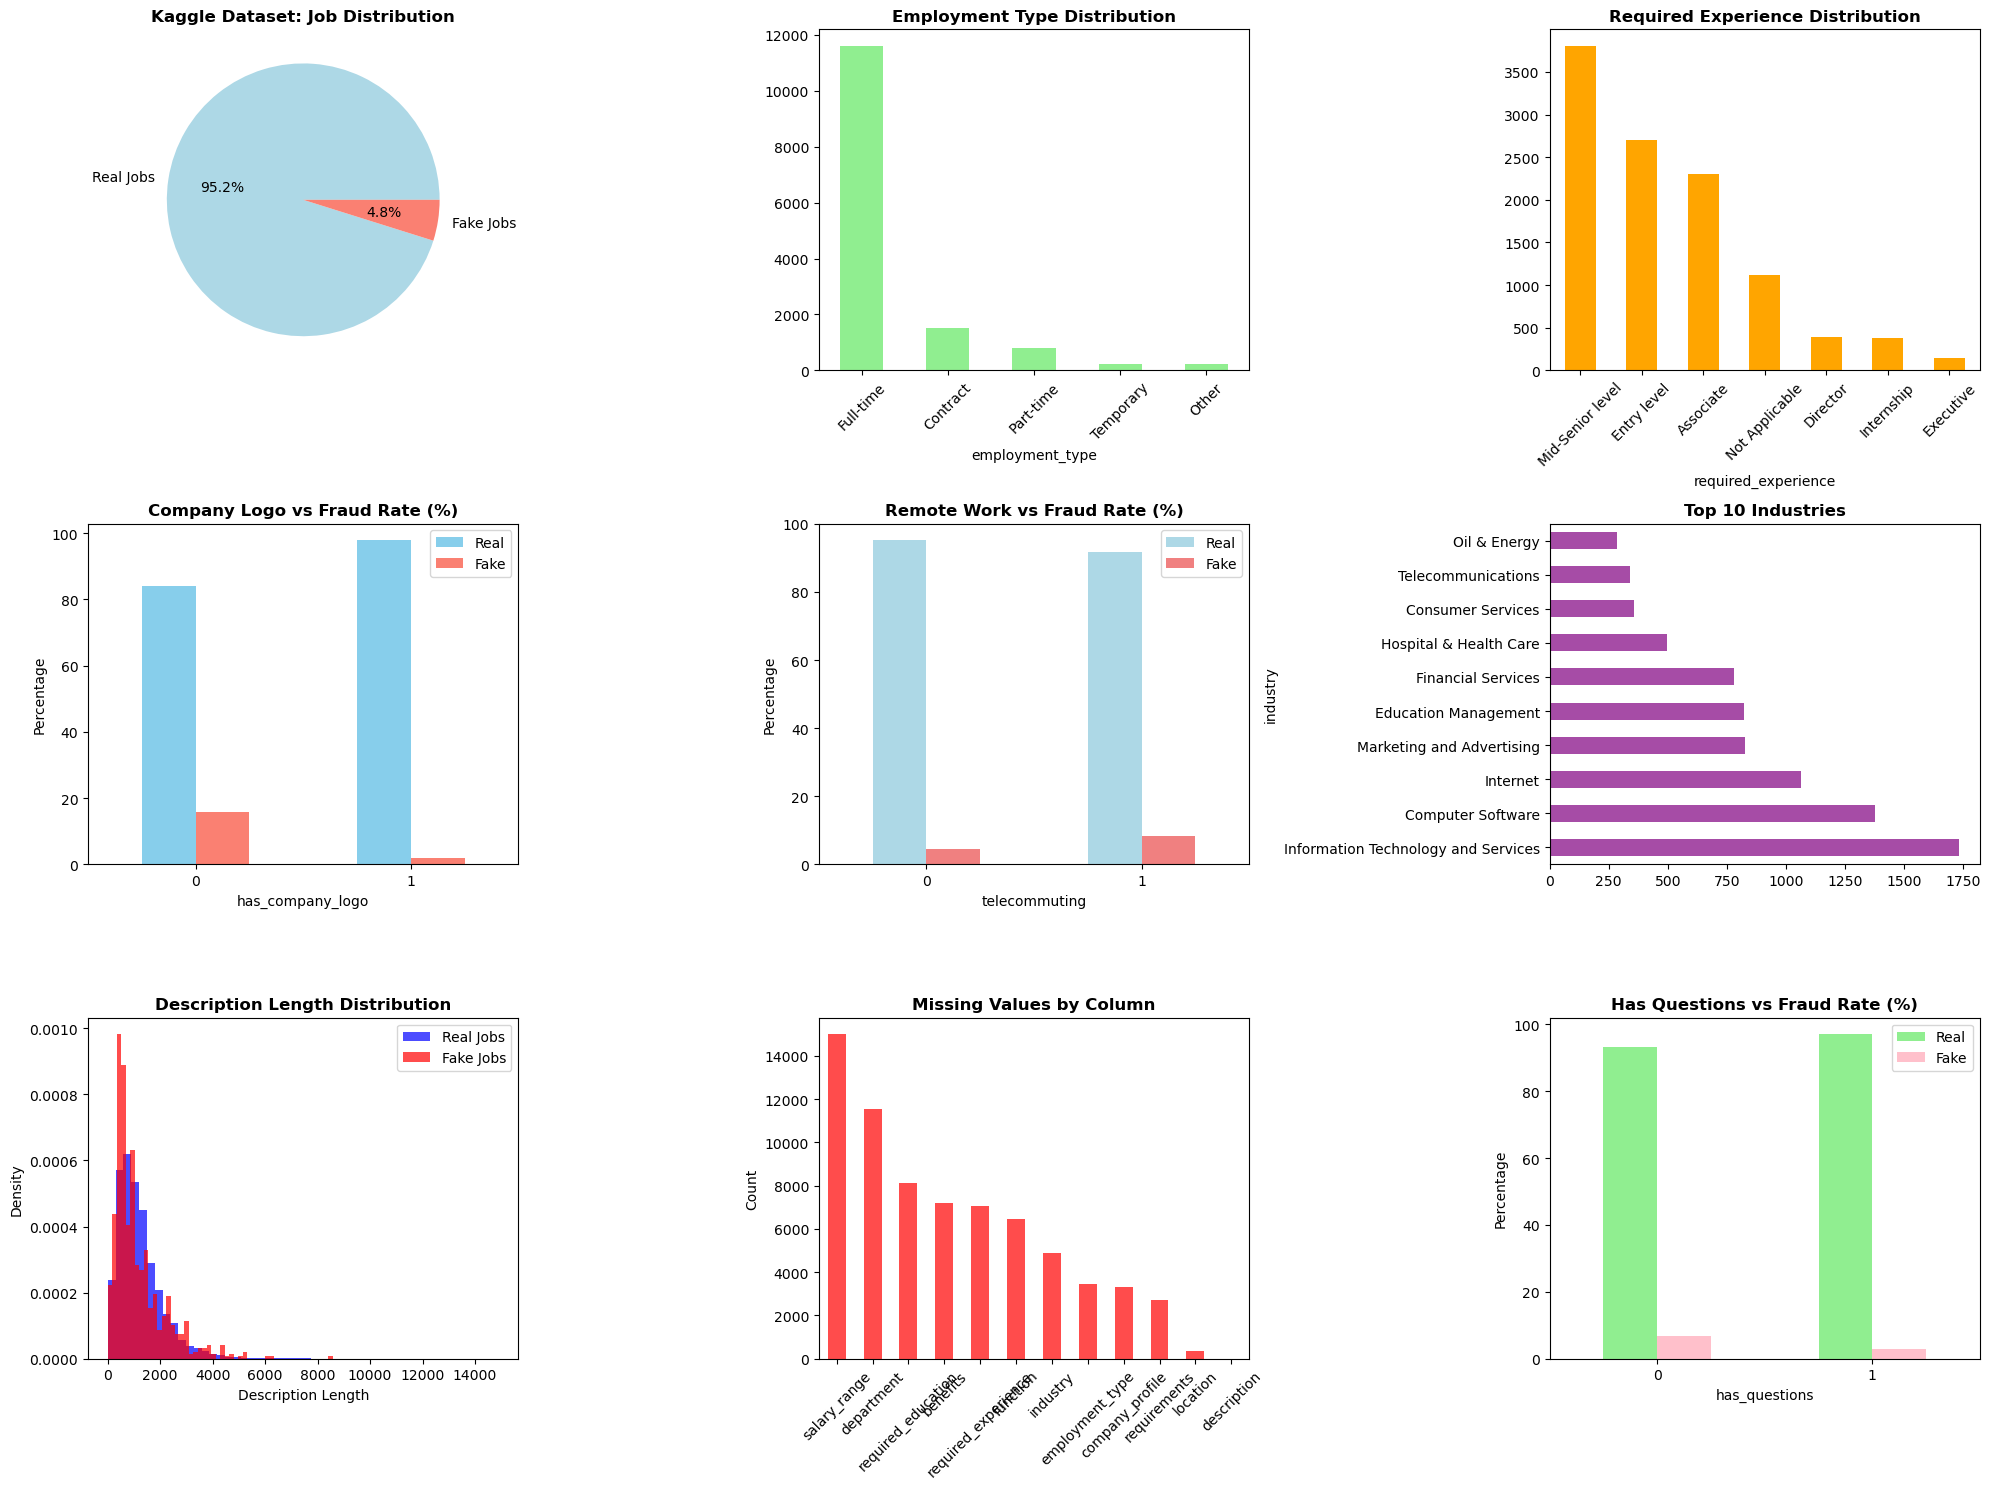


📊 Kaggle Dataset Summary:
   Total samples: 17,880
   Real jobs: 17,014
   Fake jobs: 866
   Imbalance ratio: 19.6:1

📝 Text Analysis:
   Average description length (Real): 1221 characters
   Average description length (Fake): 1155 characters
✅ Step 3 Complete: Kaggle dataset exploration finished!


In [5]:
def explore_kaggle_dataset(df):
    """Comprehensive exploration of the real Kaggle dataset"""
    
    print("🔄 Step 3: Exploring real Kaggle dataset...")
    
    # Create comprehensive visualizations for Kaggle data
    fig, axes = plt.subplots(3, 3, figsize=(20, 15))
    
    # 1. Target distribution
    target_counts = df['fraudulent'].value_counts()
    axes[0,0].pie(target_counts.values, labels=['Real Jobs', 'Fake Jobs'], 
                  autopct='%1.1f%%', colors=['lightblue', 'salmon'])
    axes[0,0].set_title('Kaggle Dataset: Job Distribution', fontweight='bold')
    
    # 2. Employment type distribution
    if 'employment_type' in df.columns:
        emp_counts = df['employment_type'].value_counts().head(8)
        emp_counts.plot(kind='bar', ax=axes[0,1], color='lightgreen')
        axes[0,1].set_title('Employment Type Distribution', fontweight='bold')
        axes[0,1].tick_params(axis='x', rotation=45)
    
    # 3. Required experience
    if 'required_experience' in df.columns:
        exp_counts = df['required_experience'].value_counts().head(8)
        exp_counts.plot(kind='bar', ax=axes[0,2], color='orange')
        axes[0,2].set_title('Required Experience Distribution', fontweight='bold')
        axes[0,2].tick_params(axis='x', rotation=45)
    
    # 4. Company logo vs fraud
    if 'has_company_logo' in df.columns:
        logo_fraud = pd.crosstab(df['has_company_logo'], df['fraudulent'], normalize='index') * 100
        logo_fraud.plot(kind='bar', ax=axes[1,0], color=['skyblue', 'salmon'])
        axes[1,0].set_title('Company Logo vs Fraud Rate (%)', fontweight='bold')
        axes[1,0].set_ylabel('Percentage')
        axes[1,0].tick_params(axis='x', rotation=0)
        axes[1,0].legend(['Real', 'Fake'])
    
    # 5. Telecommuting vs fraud
    if 'telecommuting' in df.columns:
        remote_fraud = pd.crosstab(df['telecommuting'], df['fraudulent'], normalize='index') * 100
        remote_fraud.plot(kind='bar', ax=axes[1,1], color=['lightblue', 'lightcoral'])
        axes[1,1].set_title('Remote Work vs Fraud Rate (%)', fontweight='bold')
        axes[1,1].set_ylabel('Percentage')
        axes[1,1].tick_params(axis='x', rotation=0)
        axes[1,1].legend(['Real', 'Fake'])
    
    # 6. Industry distribution (top 10)
    if 'industry' in df.columns:
        industry_counts = df['industry'].value_counts().head(10)
        industry_counts.plot(kind='barh', ax=axes[1,2], color='purple', alpha=0.7)
        axes[1,2].set_title('Top 10 Industries', fontweight='bold')
    
    # 7. Text length analysis
    if 'description' in df.columns:
        df['desc_length'] = df['description'].fillna('').astype(str).apply(len)
        real_lengths = df[df['fraudulent'] == 0]['desc_length']
        fake_lengths = df[df['fraudulent'] == 1]['desc_length']
        
        axes[2,0].hist(real_lengths, bins=50, alpha=0.7, label='Real Jobs', color='blue', density=True)
        axes[2,0].hist(fake_lengths, bins=50, alpha=0.7, label='Fake Jobs', color='red', density=True)
        axes[2,0].set_xlabel('Description Length')
        axes[2,0].set_ylabel('Density')
        axes[2,0].set_title('Description Length Distribution', fontweight='bold')
        axes[2,0].legend()
    
    # 8. Missing values heatmap
    missing_data = df.isnull().sum()
    if missing_data.sum() > 0:
        missing_df = missing_data[missing_data > 0].sort_values(ascending=False)
        missing_df.plot(kind='bar', ax=axes[2,1], color='red', alpha=0.7)
        axes[2,1].set_title('Missing Values by Column', fontweight='bold')
        axes[2,1].tick_params(axis='x', rotation=45)
        axes[2,1].set_ylabel('Count')
    else:
        axes[2,1].text(0.5, 0.5, 'No Missing Values!', 
                       horizontalalignment='center', verticalalignment='center',
                       transform=axes[2,1].transAxes, fontsize=14, color='green')
        axes[2,1].set_title('Missing Values Status', fontweight='bold')
    
    # 9. Questions vs fraud
    if 'has_questions' in df.columns:
        questions_fraud = pd.crosstab(df['has_questions'], df['fraudulent'], normalize='index') * 100
        questions_fraud.plot(kind='bar', ax=axes[2,2], color=['lightgreen', 'pink'])
        axes[2,2].set_title('Has Questions vs Fraud Rate (%)', fontweight='bold')
        axes[2,2].set_ylabel('Percentage')
        axes[2,2].tick_params(axis='x', rotation=0)
        axes[2,2].legend(['Real', 'Fake'])
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics for Kaggle dataset
    print(f"\n📊 Kaggle Dataset Summary:")
    print(f"   Total samples: {len(df):,}")
    print(f"   Real jobs: {np.sum(df['fraudulent'] == 0):,}")
    print(f"   Fake jobs: {np.sum(df['fraudulent'] == 1):,}")
    print(f"   Imbalance ratio: {np.sum(df['fraudulent'] == 0) / np.sum(df['fraudulent'] == 1):.1f}:1")
    
    if 'description' in df.columns:
        print(f"\n📝 Text Analysis:")
        real_avg_len = df[df['fraudulent'] == 0]['desc_length'].mean()
        fake_avg_len = df[df['fraudulent'] == 1]['desc_length'].mean()
        print(f"   Average description length (Real): {real_avg_len:.0f} characters")
        print(f"   Average description length (Fake): {fake_avg_len:.0f} characters")
    
    print("✅ Step 3 Complete: Kaggle dataset exploration finished!")

# Execute Step 3
if df is not None:
    explore_kaggle_dataset(df)


In [7]:
class KaggleDataPreprocessor:
    """Enhanced preprocessor specifically for the Kaggle fake job postings dataset"""
    
    def __init__(self, handle_imbalance='smote'):
        """Initialize preprocessor for Kaggle dataset"""
        print("🔄 Step 4: Initializing KaggleDataPreprocessor...")
        
        self.handle_imbalance = handle_imbalance
        
        # Enhanced text vectorizer for Kaggle dataset
        self.tfidf_vectorizer = TfidfVectorizer(
            max_features=2000,      # Reduced for regularization
            stop_words='english',
            lowercase=True,
            ngram_range=(1, 2),     # Include bigrams
            min_df=3,               # Ignore rare terms
            max_df=0.90,            # Ignore too common terms
            sublinear_tf=True       # Apply sublinear tf scaling
        )
        
        self.label_encoders = {}
        self.scaler = StandardScaler()
        self.class_weights = None
        
        # Initialize sampling methods
        if handle_imbalance == 'smote':
            self.sampler = SMOTE(random_state=42, k_neighbors=5)
        elif handle_imbalance == 'oversample':
            self.sampler = RandomOverSampler(random_state=42)
        elif handle_imbalance == 'undersample':
            self.sampler = RandomUnderSampler(random_state=42)
        elif handle_imbalance == 'smote_tomek':
            self.sampler = SMOTETomek(random_state=42)
        else:
            self.sampler = None
        
        print(f"   Imbalance handling strategy: {handle_imbalance}")
        print("✅ Step 4a Complete: KaggleDataPreprocessor initialized!")
    
    def clean_text(self, text):
        """Enhanced text cleaning for Kaggle job postings"""
        if pd.isna(text):
            return ""
        
        text = str(text).lower()
        
        # Remove URLs and emails
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        text = re.sub(r'\S+@\S+', '', text)
        
        # Remove phone numbers
        text = re.sub(r'\b\d{3}[-.]?\d{3}[-.]?\d{4}\b', '', text)
        
        # Remove excessive punctuation
        text = re.sub(r'[!]{2,}', '!', text)
        text = re.sub(r'[?]{2,}', '?', text)
        
        # Remove special characters but keep spaces
        text = re.sub(r'[^a-zA-Z\s]', ' ', text)
        
        # Remove extra whitespace
        text = ' '.join(text.split())
        
        return text
    
    def combine_text_features(self, df):
        """Combine text features from Kaggle dataset"""
        # Kaggle dataset text columns
        text_columns = ['title', 'description', 'company_profile', 'requirements', 'benefits']
        existing_text_cols = [col for col in text_columns if col in df.columns]
        
        print(f"   Processing Kaggle text columns: {existing_text_cols}")
        
        combined_text = []
        for idx, row in df.iterrows():
            text_parts = []
            
            # Title gets highest weight (repeated 3 times)
            if 'title' in existing_text_cols:
                title_clean = self.clean_text(row['title'])
                if title_clean:
                    text_parts.extend([title_clean] * 3)
            
            # Description gets medium weight (repeated 2 times)
            if 'description' in existing_text_cols:
                desc_clean = self.clean_text(row['description'])
                if desc_clean:
                    text_parts.extend([desc_clean] * 2)
            
            # Other fields get normal weight
            for col in ['company_profile', 'requirements', 'benefits']:
                if col in existing_text_cols:
                    cleaned_text = self.clean_text(row[col])
                    if cleaned_text:
                        text_parts.append(cleaned_text)
            
            combined_text.append(' '.join(text_parts))
        
        return combined_text
    
    def encode_categorical_features(self, df):
        """Encode categorical features from Kaggle dataset"""
        # Kaggle dataset categorical columns
        kaggle_categorical = [
            'employment_type', 'required_experience', 'required_education',
            'industry', 'function', 'location', 'department'
        ]
        
        categorical_columns = [col for col in kaggle_categorical if col in df.columns]
        print(f"   Processing Kaggle categorical columns: {categorical_columns}")
        
        encoded_features = []
        
        for col in categorical_columns:
            df_copy = df.copy()
            df_copy[col] = df_copy[col].fillna('Unknown')
            
            # Handle high cardinality columns specific to Kaggle dataset
            if col in ['location', 'industry', 'function', 'department']:
                # Keep only top 25 categories for Kaggle dataset
                top_categories = df_copy[col].value_counts().head(25).index
                df_copy[col] = df_copy[col].apply(lambda x: x if x in top_categories else 'Other')
            
            # Label encode
            if col not in self.label_encoders:
                self.label_encoders[col] = LabelEncoder()
                encoded = self.label_encoders[col].fit_transform(df_copy[col])
            else:
                encoded = self.label_encoders[col].transform(df_copy[col])
            
            encoded_features.append(encoded.reshape(-1, 1))
        
        if encoded_features:
            return np.hstack(encoded_features)
        else:
            return np.array([]).reshape(len(df), 0)
    
    def extract_numerical_features(self, df):
        """Extract numerical features from Kaggle dataset"""
        numerical_features = []
        
        # Kaggle dataset binary features
        kaggle_binary = ['has_company_logo', 'telecommuting', 'has_questions']
        existing_binary = [col for col in kaggle_binary if col in df.columns]
        print(f"   Processing Kaggle binary columns: {existing_binary}")
        
        for col in existing_binary:
            values = df[col].fillna(0).astype(int).values.reshape(-1, 1)
            numerical_features.append(values)
        
        # Enhanced text-derived features for Kaggle dataset
        if 'description' in df.columns:
            # Description metrics
            desc_length = df['description'].fillna('').astype(str).apply(len).values.reshape(-1, 1)
            word_count = df['description'].fillna('').astype(str).apply(lambda x: len(x.split())).values.reshape(-1, 1)
            exclamation_count = df['description'].fillna('').astype(str).apply(lambda x: x.count('!')).values.reshape(-1, 1)
            caps_ratio = df['description'].fillna('').astype(str).apply(
                lambda x: sum(1 for c in x if c.isupper()) / max(len(x), 1)
            ).values.reshape(-1, 1)
            
            # Suspicious words count
            suspicious_words = ['urgent', 'immediate', 'easy', 'money', 'fast', 'guaranteed', 'no experience']
            suspicious_count = df['description'].fillna('').astype(str).apply(
                lambda x: sum(1 for word in suspicious_words if word in x.lower())
            ).values.reshape(-1, 1)
            
            numerical_features.extend([desc_length, word_count, exclamation_count, caps_ratio, suspicious_count])
        
        if 'title' in df.columns:
            # Title metrics
            title_length = df['title'].fillna('').astype(str).apply(len).values.reshape(-1, 1)
            title_word_count = df['title'].fillna('').astype(str).apply(lambda x: len(x.split())).values.reshape(-1, 1)
            title_caps_ratio = df['title'].fillna('').astype(str).apply(
                lambda x: sum(1 for c in x if c.isupper()) / max(len(x), 1)
            ).values.reshape(-1, 1)
            
            numerical_features.extend([title_length, title_word_count, title_caps_ratio])
        
        # Additional Kaggle-specific features
        if 'requirements' in df.columns:
            has_requirements = (df['requirements'].fillna('').astype(str).apply(len) > 0).astype(int).values.reshape(-1, 1)
            req_length = df['requirements'].fillna('').astype(str).apply(len).values.reshape(-1, 1)
            numerical_features.extend([has_requirements, req_length])
        
        if 'salary_range' in df.columns:
            has_salary = (~df['salary_range'].isna()).astype(int).values.reshape(-1, 1)
            numerical_features.append(has_salary)
        
        if 'company_profile' in df.columns:
            has_company_profile = (df['company_profile'].fillna('').astype(str).apply(len) > 0).astype(int).values.reshape(-1, 1)
            company_profile_length = df['company_profile'].fillna('').astype(str).apply(len).values.reshape(-1, 1)
            numerical_features.extend([has_company_profile, company_profile_length])
        
        if numerical_features:
            return np.hstack(numerical_features)
        else:
            return np.array([]).reshape(len(df), 0)
    
    def calculate_class_weights(self, y):
        """Calculate class weights for Kaggle dataset"""
        classes = np.unique(y)
        class_weights = compute_class_weight('balanced', classes=classes, y=y)
        self.class_weights = dict(zip(classes, class_weights))
        
        print(f"   Calculated class weights for Kaggle data: {self.class_weights}")
        return self.class_weights
    
    def fit_transform(self, df, y=None):
        """Fit preprocessor and transform Kaggle dataset"""
        print("🔄 Step 4b: Starting preprocessing of Kaggle dataset...")
        
        if y is None:
            y = df['fraudulent'].values
        
        # 1. Process text features
        print("📝 Processing Kaggle text features...")
        combined_text = self.combine_text_features(df)
        text_features = self.tfidf_vectorizer.fit_transform(combined_text).toarray()
        print(f"   Text features shape: {text_features.shape}")
        
        # 2. Process categorical features
        print("🏷️  Processing Kaggle categorical features...")
        categorical_features = self.encode_categorical_features(df)
        print(f"   Categorical features shape: {categorical_features.shape}")
        
        # 3. Process numerical features
        print("🔢 Processing Kaggle numerical features...")
        numerical_features = self.extract_numerical_features(df)
        print(f"   Numerical features shape: {numerical_features.shape}")
        
        # 4. Combine all features
        print("🔗 Combining all Kaggle features...")
        all_features = [text_features]
        
        if categorical_features.shape[1] > 0:
            all_features.append(categorical_features)
        
        if numerical_features.shape[1] > 0:
            all_features.append(numerical_features)
        
        final_features = np.hstack(all_features)
        print(f"   Combined features shape: {final_features.shape}")
        
        # 5. Scale features
        print("⚖️  Scaling Kaggle features...")
        final_features = self.scaler.fit_transform(final_features)
        
        # 6. Handle class imbalance for Kaggle dataset
        if self.handle_imbalance == 'class_weights':
            print("⚖️  Calculating class weights for Kaggle data...")
            self.calculate_class_weights(y)
            X_balanced, y_balanced = final_features, y
        elif self.sampler is not None:
            print(f"🎯 Applying {self.handle_imbalance} sampling to Kaggle data...")
            print(f"   Original Kaggle distribution: {np.bincount(y)}")
            X_balanced, y_balanced = self.sampler.fit_resample(final_features, y)
            print(f"   Balanced Kaggle distribution: {np.bincount(y_balanced)}")
        else:
            print("   No sampling applied to Kaggle data")
            X_balanced, y_balanced = final_features, y
        
        print(f"✅ Step 4b Complete: Kaggle preprocessing finished! Final shape: {X_balanced.shape}")
        return X_balanced, y_balanced
    
    def transform(self, df):
        """Transform new data using fitted preprocessor"""
        combined_text = self.combine_text_features(df)
        text_features = self.tfidf_vectorizer.transform(combined_text).toarray()
        
        categorical_features = self.encode_categorical_features(df)
        numerical_features = self.extract_numerical_features(df)
        
        all_features = [text_features]
        if categorical_features.shape[1] > 0:
            all_features.append(categorical_features)
        if numerical_features.shape[1] > 0:
            all_features.append(numerical_features)
        
        final_features = np.hstack(all_features)
        final_features = self.scaler.transform(final_features)
        
        return final_features

print("✅ Step 4 Complete: KaggleDataPreprocessor class defined!")


✅ Step 4 Complete: KaggleDataPreprocessor class defined!


In [9]:
class EnhancedRegularizedNeuralNetwork:
    """Enhanced neural network with strong regularization for Kaggle dataset"""
    
    def __init__(self, input_size, hidden_sizes=[64, 32], learning_rate=0.0001, 
                 dropout_rate=0.6, l2_lambda=0.01, early_stopping_patience=15):
        """
        Initialize enhanced neural network for Kaggle dataset
        
        Parameters:
        input_size: number of input features
        hidden_sizes: smaller network architecture for regularization
        learning_rate: reduced learning rate
        dropout_rate: increased dropout
        l2_lambda: stronger L2 regularization
        early_stopping_patience: early stopping patience
        """
        self.learning_rate = learning_rate
        self.dropout_rate = dropout_rate
        self.l2_lambda = l2_lambda
        self.early_stopping_patience = early_stopping_patience
        self.layers = []
        
        # Smaller network architecture for Kaggle dataset
        layer_sizes = [input_size] + hidden_sizes + [1]
        
        print(f"🧠 Enhanced Neural Network for Kaggle Dataset:")
        print(f"   Architecture: {layer_sizes}")
        print(f"   Learning rate: {self.learning_rate}")
        print(f"   Dropout rate: {self.dropout_rate}")
        print(f"   L2 lambda: {self.l2_lambda}")
        print(f"   Early stopping patience: {self.early_stopping_patience}")
        
        for i in range(len(layer_sizes) - 1):
            # Xavier initialization (more conservative)
            fan_in = layer_sizes[i]
            fan_out = layer_sizes[i+1]
            limit = np.sqrt(6.0 / (fan_in + fan_out))
            weight = np.random.uniform(-limit, limit, (fan_in, fan_out))
            
            bias = np.zeros((1, layer_sizes[i+1]))
            
            self.layers.append({
                'weight': weight,
                'bias': bias,
                'activation': None,
                'z': None,
                'dropout_mask': None
            })
        
        print("✅ Enhanced network for Kaggle dataset initialized!")
    
    def sigmoid(self, z):
        """Sigmoid with numerical stability"""
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))
    
    def relu(self, z):
        """Standard ReLU activation"""
        return np.maximum(0, z)
    
    def relu_derivative(self, z):
        """ReLU derivative"""
        return (z > 0).astype(float)
    
    def apply_dropout(self, x, training=True):
        """Enhanced dropout with higher rate"""
        if training and self.dropout_rate > 0:
            mask = np.random.binomial(1, 1 - self.dropout_rate, x.shape) / (1 - self.dropout_rate)
            return x * mask, mask
        else:
            return x, None
    
    def forward_propagation(self, X, training=True):
        """Forward propagation with enhanced regularization"""
        current_input = X
        
        for i, layer in enumerate(self.layers):
            # Linear transformation
            z = np.dot(current_input, layer['weight']) + layer['bias']
            layer['z'] = z
            
            if i == len(self.layers) - 1:  # Output layer
                activation = self.sigmoid(z)
            else:  # Hidden layers
                activation = self.relu(z)
                
                # Apply dropout with higher rate
                if training:
                    activation, dropout_mask = self.apply_dropout(activation, training)
                    layer['dropout_mask'] = dropout_mask
            
            layer['activation'] = activation
            current_input = activation
        
        return current_input
    
    def compute_regularized_loss(self, y_true, y_pred):
        """Enhanced loss with stronger regularization for Kaggle dataset"""
        # Clip predictions
        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
        
        # Cross-entropy loss
        ce_loss = -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
        
        # Strong L2 regularization
        l2_reg = 0
        for layer in self.layers:
            l2_reg += np.sum(layer['weight'] ** 2)
        l2_reg *= self.l2_lambda
        
        # L1 regularization (additional sparsity)
        l1_reg = 0
        for layer in self.layers:
            l1_reg += np.sum(np.abs(layer['weight']))
        l1_reg *= (self.l2_lambda * 0.1)  # 10% of L2 strength
        
        total_loss = ce_loss + l2_reg + l1_reg
        return total_loss
    
    def backward_propagation(self, X, y_true, y_pred):
        """Backward propagation with regularization"""
        m = X.shape[0]
        gradients = []
        
        # Output layer gradient
        dz = y_pred - y_true.reshape(-1, 1)
        
        # Backpropagate through layers
        for i in reversed(range(len(self.layers))):
            layer = self.layers[i]
            
            if i == 0:
                prev_activation = X
            else:
                prev_activation = self.layers[i-1]['activation']
            
            # Compute gradients
            dw = np.dot(prev_activation.T, dz) / m
            db = np.mean(dz, axis=0, keepdims=True)
            
            # Add L2 regularization to weights
            dw += self.l2_lambda * layer['weight']
            
            # Add L1 regularization to weights
            dw += (self.l2_lambda * 0.1) * np.sign(layer['weight'])
            
            gradients.insert(0, {'dw': dw, 'db': db})
            
            # Compute gradient for next layer
            if i > 0:
                da_prev = np.dot(dz, layer['weight'].T)
                
                # Apply dropout mask if it exists
                if self.layers[i-1]['dropout_mask'] is not None:
                    da_prev *= self.layers[i-1]['dropout_mask']
                
                dz = da_prev * self.relu_derivative(self.layers[i-1]['z'])
        
        return gradients
    
    def update_parameters(self, gradients):
        """Parameter update with gradient clipping"""
        for i, (layer, grad) in enumerate(zip(self.layers, gradients)):
            # Gradient clipping
            grad['dw'] = np.clip(grad['dw'], -1.0, 1.0)
            grad['db'] = np.clip(grad['db'], -1.0, 1.0)
            
            # Update parameters
            layer['weight'] -= self.learning_rate * grad['dw']
            layer['bias'] -= self.learning_rate * grad['db']
    
    def train(self, X, y, epochs=150, batch_size=32, validation_split=0.2, verbose=True):
        """Enhanced training for Kaggle dataset"""
        print(f"🚀 Starting enhanced training on Kaggle dataset for {epochs} epochs...")
        
        # Stratified split for validation
        X_train, X_val, y_train, y_val = train_test_split(
            X, y, test_size=validation_split, random_state=42, stratify=y
        )
        
        print(f"   Training samples: {len(X_train):,}")
        print(f"   Validation samples: {len(X_val):,}")
        print(f"   Training class distribution: {np.bincount(y_train)}")
        print(f"   Validation class distribution: {np.bincount(y_val)}")
        
        # Training history
        history = {
            'train_losses': [], 'val_losses': [],
            'train_accuracies': [], 'val_accuracies': [],
            'train_f1': [], 'val_f1': [],
            'train_precision': [], 'val_precision': [],
            'train_recall': [], 'val_recall': []
        }
        
        # Early stopping variables
        best_val_f1 = 0
        patience_counter = 0
        best_weights = None
        
        for epoch in range(epochs):
            # Shuffle training data
            train_indices = np.random.permutation(len(X_train))
            epoch_train_loss = 0
            num_batches = 0
            
            # Mini-batch training with smaller batches
            for i in range(0, len(X_train), batch_size):
                batch_indices = train_indices[i:i+batch_size]
                X_batch = X_train[batch_indices]
                y_batch = y_train[batch_indices]
                
                # Forward propagation
                y_pred = self.forward_propagation(X_batch, training=True)
                
                # Compute loss
                batch_loss = self.compute_regularized_loss(y_batch, y_pred)
                epoch_train_loss += batch_loss
                num_batches += 1
                
                # Backward propagation
                gradients = self.backward_propagation(X_batch, y_batch, y_pred)
                
                # Update parameters
                self.update_parameters(gradients)
            
            # Calculate epoch metrics
            avg_train_loss = epoch_train_loss / num_batches
            
            # Validation metrics
            y_val_pred = self.forward_propagation(X_val, training=False)
            val_loss = self.compute_regularized_loss(y_val, y_val_pred)
            
            # Calculate comprehensive metrics
            train_pred = self.forward_propagation(X_train, training=False)
            
            # Training metrics
            train_acc = np.mean((train_pred > 0.5) == y_train.reshape(-1, 1))
            train_f1 = f1_score(y_train, (train_pred > 0.5).astype(int))
            train_precision = precision_score(y_train, (train_pred > 0.5).astype(int))
            train_recall = recall_score(y_train, (train_pred > 0.5).astype(int))
            
            # Validation metrics
            val_acc = np.mean((y_val_pred > 0.5) == y_val.reshape(-1, 1))
            val_f1 = f1_score(y_val, (y_val_pred > 0.5).astype(int))
            val_precision = precision_score(y_val, (y_val_pred > 0.5).astype(int))
            val_recall = recall_score(y_val, (y_val_pred > 0.5).astype(int))
            
            # Store history
            history['train_losses'].append(avg_train_loss)
            history['val_losses'].append(val_loss)
            history['train_accuracies'].append(train_acc)
            history['val_accuracies'].append(val_acc)
            history['train_f1'].append(train_f1)
            history['val_f1'].append(val_f1)
            history['train_precision'].append(train_precision)
            history['val_precision'].append(val_precision)
            history['train_recall'].append(train_recall)
            history['val_recall'].append(val_recall)
            
            # Enhanced early stopping
            if val_f1 > best_val_f1:
                best_val_f1 = val_f1
                patience_counter = 0
                # Save best weights
                best_weights = [layer['weight'].copy() for layer in self.layers]
            else:
                patience_counter += 1
            
            if verbose and epoch % 10 == 0:
                print(f"   Epoch {epoch:3d}: Loss: {avg_train_loss:.4f}/{val_loss:.4f}, "
                      f"Acc: {train_acc:.4f}/{val_acc:.4f}, "
                      f"F1: {train_f1:.4f}/{val_f1:.4f}")
            
            # Early stopping with patience
            if patience_counter >= self.early_stopping_patience:
                print(f"   Early stopping at epoch {epoch} (best val F1: {best_val_f1:.4f})")
                # Restore best weights
                if best_weights is not None:
                    for i, layer in enumerate(self.layers):
                        layer['weight'] = best_weights[i]
                break
        
        print("✅ Enhanced training on Kaggle dataset completed!")
        return history
    
    def predict(self, X):
        """Make predictions"""
        y_pred = self.forward_propagation(X, training=False)
        return (y_pred > 0.5).astype(int).flatten()
    
    def predict_proba(self, X):
        """Get prediction probabilities"""
        return self.forward_propagation(X, training=False).flatten()

print("✅ Step 5 Complete: EnhancedRegularizedNeuralNetwork class defined!")


✅ Step 5 Complete: EnhancedRegularizedNeuralNetwork class defined!


In [11]:
if df is not None:
    print("🔄 Step 6: Preprocessing dataset...")
    
    # Initialize preprocessor for dataset
    kaggle_preprocessor = KaggleDataPreprocessor(handle_imbalance='smote')
    
    # Preprocess data
    X, y = kaggle_preprocessor.fit_transform(df)
    
    print(f"\n📊 Final Kaggle preprocessing results:")
    print(f"   Features: {X.shape[1]:,}")
    print(f"   Samples: {X.shape[0]:,}")
    print(f"   Class distribution: {np.bincount(y)}")
    print(f"   Feature value range: [{X.min():.4f}, {X.max():.4f}]")
    
    print("✅ Step 6 Complete: data preprocessing finished!")
    
else:
    print("❌ Cannot proceed without dataset")


🔄 Step 6: Preprocessing dataset...
🔄 Step 4: Initializing KaggleDataPreprocessor...
   Imbalance handling strategy: smote
✅ Step 4a Complete: KaggleDataPreprocessor initialized!
🔄 Step 4b: Starting preprocessing of Kaggle dataset...
📝 Processing Kaggle text features...
   Processing Kaggle text columns: ['title', 'description', 'company_profile', 'requirements', 'benefits']
   Text features shape: (17880, 2000)
🏷️  Processing Kaggle categorical features...
   Processing Kaggle categorical columns: ['employment_type', 'required_experience', 'required_education', 'industry', 'function', 'location', 'department']
   Categorical features shape: (17880, 7)
🔢 Processing Kaggle numerical features...
   Processing Kaggle binary columns: ['has_company_logo', 'telecommuting', 'has_questions']
   Numerical features shape: (17880, 16)
🔗 Combining all Kaggle features...
   Combined features shape: (17880, 2023)
⚖️  Scaling Kaggle features...
🎯 Applying smote sampling to Kaggle data...
   Original K

  File "C:\Users\Narender\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\Narender\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Narender\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\Narender\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


   Balanced Kaggle distribution: [17014 17014]
✅ Step 4b Complete: Kaggle preprocessing finished! Final shape: (34028, 2023)

📊 Final Kaggle preprocessing results:
   Features: 2,023
   Samples: 34,028
   Class distribution: [17014 17014]
   Feature value range: [-3.9829, 44.1175]
✅ Step 6 Complete: data preprocessing finished!


In [13]:
if 'X' in locals() and 'y' in locals():
    print("🔄 Step 7: Splitting Kaggle data and initializing enhanced model...")
    
    # Stratified split to maintain class distribution
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    print(f"📊 Kaggle data split results:")
    print(f"   Training set: {X_train.shape[0]:,} samples")
    print(f"   Test set: {X_test.shape[0]:,} samples")
    print(f"   Features: {X_train.shape[1]:,}")
    
    print(f"\n🎯 Class distribution after split:")
    train_dist = np.bincount(y_train)
    test_dist = np.bincount(y_test)
    print(f"   Training - Real: {train_dist[0]:,}, Fake: {train_dist[1]:,}")
    print(f"   Test - Real: {test_dist[0]:,}, Fake: {test_dist[1]:,}")
    
    # Initialize enhanced model for Kaggle dataset
    enhanced_nn = EnhancedRegularizedNeuralNetwork(
        input_size=X_train.shape[1],
        hidden_sizes=[64, 32],      # Smaller network for regularization
        learning_rate=0.0001,       # Lower learning rate
        dropout_rate=0.6,           # Higher dropout
        l2_lambda=0.01,             # Stronger L2 regularization
        early_stopping_patience=15  # Early stopping
    )
    
    print("✅ Step 7 Complete: Kaggle data split and enhanced model initialized!")
    
else:
    print("❌ Cannot proceed. Please ensure Kaggle data is preprocessed.")


🔄 Step 7: Splitting Kaggle data and initializing enhanced model...
📊 Kaggle data split results:
   Training set: 27,222 samples
   Test set: 6,806 samples
   Features: 2,023

🎯 Class distribution after split:
   Training - Real: 13,611, Fake: 13,611
   Test - Real: 3,403, Fake: 3,403
🧠 Enhanced Neural Network for Kaggle Dataset:
   Architecture: [2023, 64, 32, 1]
   Learning rate: 0.0001
   Dropout rate: 0.6
   L2 lambda: 0.01
   Early stopping patience: 15
✅ Enhanced network for Kaggle dataset initialized!
✅ Step 7 Complete: Kaggle data split and enhanced model initialized!


In [15]:
if 'enhanced_nn' in locals():
    print("🔄 Step 8: Training enhanced model on Kaggle dataset...")
    
    history = enhanced_nn.train(
        X_train, y_train,
        epochs=150,
        batch_size=32,              # Smaller batch size
        validation_split=0.2,
        verbose=True
    )
    
    print("✅ Step 8 Complete: Enhanced model training on Kaggle dataset finished!")
    
else:
    print("❌ Enhanced neural network not initialized.")


🔄 Step 8: Training enhanced model on Kaggle dataset...
🚀 Starting enhanced training on Kaggle dataset for 150 epochs...
   Training samples: 21,777
   Validation samples: 5,445
   Training class distribution: [10888 10889]
   Validation class distribution: [2723 2722]
   Epoch   0: Loss: 6.6864/6.2092, Acc: 0.5242/0.5304, F1: 0.6513/0.6535
   Epoch  10: Loss: 6.1518/5.9440, Acc: 0.8177/0.8123, F1: 0.8221/0.8191
   Epoch  20: Loss: 5.9299/5.7740, Acc: 0.8876/0.8815, F1: 0.8891/0.8836
   Epoch  30: Loss: 5.7625/5.6209, Acc: 0.9147/0.9078, F1: 0.9168/0.9105
   Epoch  40: Loss: 5.6267/5.4856, Acc: 0.9251/0.9196, F1: 0.9274/0.9224
   Epoch  50: Loss: 5.5078/5.3679, Acc: 0.9327/0.9253, F1: 0.9350/0.9281
   Epoch  60: Loss: 5.4064/5.2648, Acc: 0.9381/0.9317, F1: 0.9403/0.9343
   Epoch  70: Loss: 5.3238/5.1736, Acc: 0.9432/0.9374, F1: 0.9451/0.9397
   Epoch  80: Loss: 5.2440/5.0913, Acc: 0.9479/0.9405, F1: 0.9496/0.9427
   Epoch  90: Loss: 5.1594/5.0138, Acc: 0.9532/0.9453, F1: 0.9547/0.9472
 

In [17]:
if 'enhanced_nn' in locals() and 'history' in locals():
    print("🔄 Step 9: Evaluating enhanced model on Kaggle dataset...")
    
    # Make predictions
    y_train_pred = enhanced_nn.predict(X_train)
    y_test_pred = enhanced_nn.predict(X_test)
    y_train_proba = enhanced_nn.predict_proba(X_train)
    y_test_proba = enhanced_nn.predict_proba(X_test)
    
    def evaluate_kaggle_model(y_true, y_pred, y_proba, dataset_name):
        """Comprehensive evaluation for Kaggle dataset"""
        
        print(f"\n📊 {dataset_name} Set Results (Kaggle Dataset):")
        print("=" * 60)
        
        # Basic metrics
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        auc = roc_auc_score(y_true, y_proba)
        
        print(f"Accuracy:  {accuracy:.4f}")
        print(f"Precision: {precision:.4f} (of predicted fakes, how many are actually fake)")
        print(f"Recall:    {recall:.4f} (of actual fakes, how many we caught)")
        print(f"F1-Score:  {f1:.4f} (harmonic mean of precision and recall)")
        print(f"ROC-AUC:   {auc:.4f}")
        
        # Confusion matrix analysis
        cm = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = cm.ravel()
        
        print(f"\nConfusion Matrix Analysis:")
        print(f"True Negatives (Real jobs correctly identified):  {tn:,}")
        print(f"False Positives (Real jobs marked as fake):       {fp:,}")
        print(f"False Negatives (Fake jobs missed):               {fn:,}")
        print(f"True Positives (Fake jobs correctly identified):  {tp:,}")
        
        # Additional metrics for Kaggle dataset
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        
        print(f"\nSpecificity (True Negative Rate): {specificity:.4f}")
        print(f"Sensitivity (True Positive Rate): {sensitivity:.4f}")
        
        # Business impact metrics
        if fp > 0:
            fp_rate = fp / (tn + fp)
            print(f"False Positive Rate: {fp_rate:.4f} (Real jobs incorrectly flagged)")
        
        if fn > 0:
            fn_rate = fn / (tp + fn)
            print(f"False Negative Rate: {fn_rate:.4f} (Fake jobs that got through)")
        
        return {
            'accuracy': accuracy, 'precision': precision, 'recall': recall,
            'f1': f1, 'auc': auc, 'specificity': specificity, 'sensitivity': sensitivity,
            'cm': cm
        }
    
    # Evaluate both sets
    train_metrics = evaluate_kaggle_model(y_train, y_train_pred, y_train_proba, "Training")
    test_metrics = evaluate_kaggle_model(y_test, y_test_pred, y_test_proba, "Test")
    
    # Detailed classification report
    print(f"\n📋 Detailed Test Set Classification Report (Kaggle Dataset):")
    print(classification_report(y_test, y_test_pred, 
                              target_names=['Real Job', 'Fake Job'],
                              digits=4))
    
    # Check for overfitting
    train_f1, test_f1 = train_metrics['f1'], test_metrics['f1']
    if train_f1 - test_f1 > 0.05:
        print(f"\n⚠️  Warning: Possible overfitting detected!")
        print(f"   Training F1: {train_f1:.4f}")
        print(f"   Test F1: {test_f1:.4f}")
        print(f"   Difference: {train_f1 - test_f1:.4f}")
    else:
        print(f"\n✅ Good generalization achieved on Kaggle dataset")
        print(f"   Training-Test F1 difference: {train_f1 - test_f1:.4f}")
    
    # Expected performance ranges for Kaggle dataset
    print(f"\n🎯 Performance Assessment:")
    if test_metrics['accuracy'] > 0.95:
        print(f"   ⚠️  Accuracy ({test_metrics['accuracy']:.4f}) is still very high - may need more regularization")
    elif test_metrics['accuracy'] > 0.85:
        print(f"   ✅ Accuracy ({test_metrics['accuracy']:.4f}) is in realistic range for fraud detection")
    else:
        print(f"   📈 Accuracy ({test_metrics['accuracy']:.4f}) - model may need improvement")
    
    print("✅ Step 9 Complete: Enhanced model evaluation on Kaggle dataset finished!")

else:
    print("❌ Model evaluation requires trained enhanced neural network.")


🔄 Step 9: Evaluating enhanced model on Kaggle dataset...

📊 Training Set Results (Kaggle Dataset):
Accuracy:  0.9699
Precision: 0.9507 (of predicted fakes, how many are actually fake)
Recall:    0.9912 (of actual fakes, how many we caught)
F1-Score:  0.9705 (harmonic mean of precision and recall)
ROC-AUC:   0.9962

Confusion Matrix Analysis:
True Negatives (Real jobs correctly identified):  12,912
False Positives (Real jobs marked as fake):       699
False Negatives (Fake jobs missed):               120
True Positives (Fake jobs correctly identified):  13,491

Specificity (True Negative Rate): 0.9486
Sensitivity (True Positive Rate): 0.9912
False Positive Rate: 0.0514 (Real jobs incorrectly flagged)
False Negative Rate: 0.0088 (Fake jobs that got through)

📊 Test Set Results (Kaggle Dataset):
Accuracy:  0.9674
Precision: 0.9459 (of predicted fakes, how many are actually fake)
Recall:    0.9915 (of actual fakes, how many we caught)
F1-Score:  0.9681 (harmonic mean of precision and recal

In [19]:
def comprehensive_kaggle_cross_validation(X, y, k=5):
    """Comprehensive cross-validation specifically for Kaggle dataset"""
    
    print("🔄 Step 10: Starting comprehensive cross-validation on Kaggle dataset...")
    
    # Stratified K-Fold Cross-Validation
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    f1_scores = []
    precision_scores = []
    recall_scores = []
    accuracy_scores = []
    
    fold = 1
    
    for train_index, val_index in skf.split(X, y):
        print(f"\n📊 Fold {fold}/{k} (Kaggle Dataset):")
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        
        print(f"   Train: {len(X_train):,}, Val: {len(X_val):,}")
        print(f"   Train distribution: {np.bincount(y_train)}")
        print(f"   Val distribution: {np.bincount(y_val)}")
        
        # Initialize model with strong regularization for Kaggle dataset
        model = EnhancedRegularizedNeuralNetwork(
            input_size=X_train.shape[1],
            hidden_sizes=[64, 32],      # Smaller network
            learning_rate=0.0001,       # Lower learning rate
            dropout_rate=0.6,           # Higher dropout
            l2_lambda=0.01,             # Stronger L2
            early_stopping_patience=10
        )
        
        # Train model
        history = model.train(
            X_train, y_train, 
            epochs=100, 
            batch_size=32, 
            validation_split=0.15, 
            verbose=False
        )
        
        # Evaluate on validation set
        y_val_pred = model.predict(X_val)
        y_val_proba = model.predict_proba(X_val)
        
        # Calculate metrics
        f1 = f1_score(y_val, y_val_pred)
        precision = precision_score(y_val, y_val_pred)
        recall = recall_score(y_val, y_val_pred)
        accuracy = accuracy_score(y_val, y_val_pred)
        
        f1_scores.append(f1)
        precision_scores.append(precision)
        recall_scores.append(recall)
        accuracy_scores.append(accuracy)
        
        print(f"   Results: Acc={accuracy:.4f}, F1={f1:.4f}, Prec={precision:.4f}, Rec={recall:.4f}")
        fold += 1
    
    # Summary statistics
    print(f"\n📊 Cross-Validation Results Summary (Kaggle Dataset):")
    print(f"   Accuracy:  {np.mean(accuracy_scores):.4f} ± {np.std(accuracy_scores):.4f}")
    print(f"   F1-Score:  {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")
    print(f"   Precision: {np.mean(precision_scores):.4f} ± {np.std(precision_scores):.4f}")
    print(f"   Recall:    {np.mean(recall_scores):.4f} ± {np.std(recall_scores):.4f}")
    
    # Performance assessment
    mean_accuracy = np.mean(accuracy_scores)
    if mean_accuracy > 0.95:
        print(f"\n⚠️  CV Accuracy ({mean_accuracy:.4f}) is very high - consider more regularization")
    elif mean_accuracy > 0.85:
        print(f"\n✅ CV Accuracy ({mean_accuracy:.4f}) is in realistic range")
    else:
        print(f"\n📈 CV Accuracy ({mean_accuracy:.4f}) - model performance could be improved")
    
    print("✅ Step 10 Complete: Cross-validation on Kaggle dataset finished!")
    
    return {
        'accuracy_scores': accuracy_scores,
        'f1_scores': f1_scores,
        'precision_scores': precision_scores,
        'recall_scores': recall_scores
    }

# Run cross-validation on Kaggle dataset
if 'X' in locals() and 'y' in locals():
    cv_results = comprehensive_kaggle_cross_validation(X, y, k=5)


🔄 Step 10: Starting comprehensive cross-validation on Kaggle dataset...

📊 Fold 1/5 (Kaggle Dataset):
   Train: 27,222, Val: 6,806
   Train distribution: [13611 13611]
   Val distribution: [3403 3403]
🧠 Enhanced Neural Network for Kaggle Dataset:
   Architecture: [2023, 64, 32, 1]
   Learning rate: 0.0001
   Dropout rate: 0.6
   L2 lambda: 0.01
   Early stopping patience: 10
✅ Enhanced network for Kaggle dataset initialized!
🚀 Starting enhanced training on Kaggle dataset for 100 epochs...
   Training samples: 23,138
   Validation samples: 4,084
   Training class distribution: [11569 11569]
   Validation class distribution: [2042 2042]
✅ Enhanced training on Kaggle dataset completed!
   Results: Acc=0.9503, F1=0.9521, Prec=0.9195, Rec=0.9871

📊 Fold 2/5 (Kaggle Dataset):
   Train: 27,222, Val: 6,806
   Train distribution: [13611 13611]
   Val distribution: [3403 3403]
🧠 Enhanced Neural Network for Kaggle Dataset:
   Architecture: [2023, 64, 32, 1]
   Learning rate: 0.0001
   Dropout rat

🔄 Step 11: Creating comprehensive visualizations for Kaggle results...


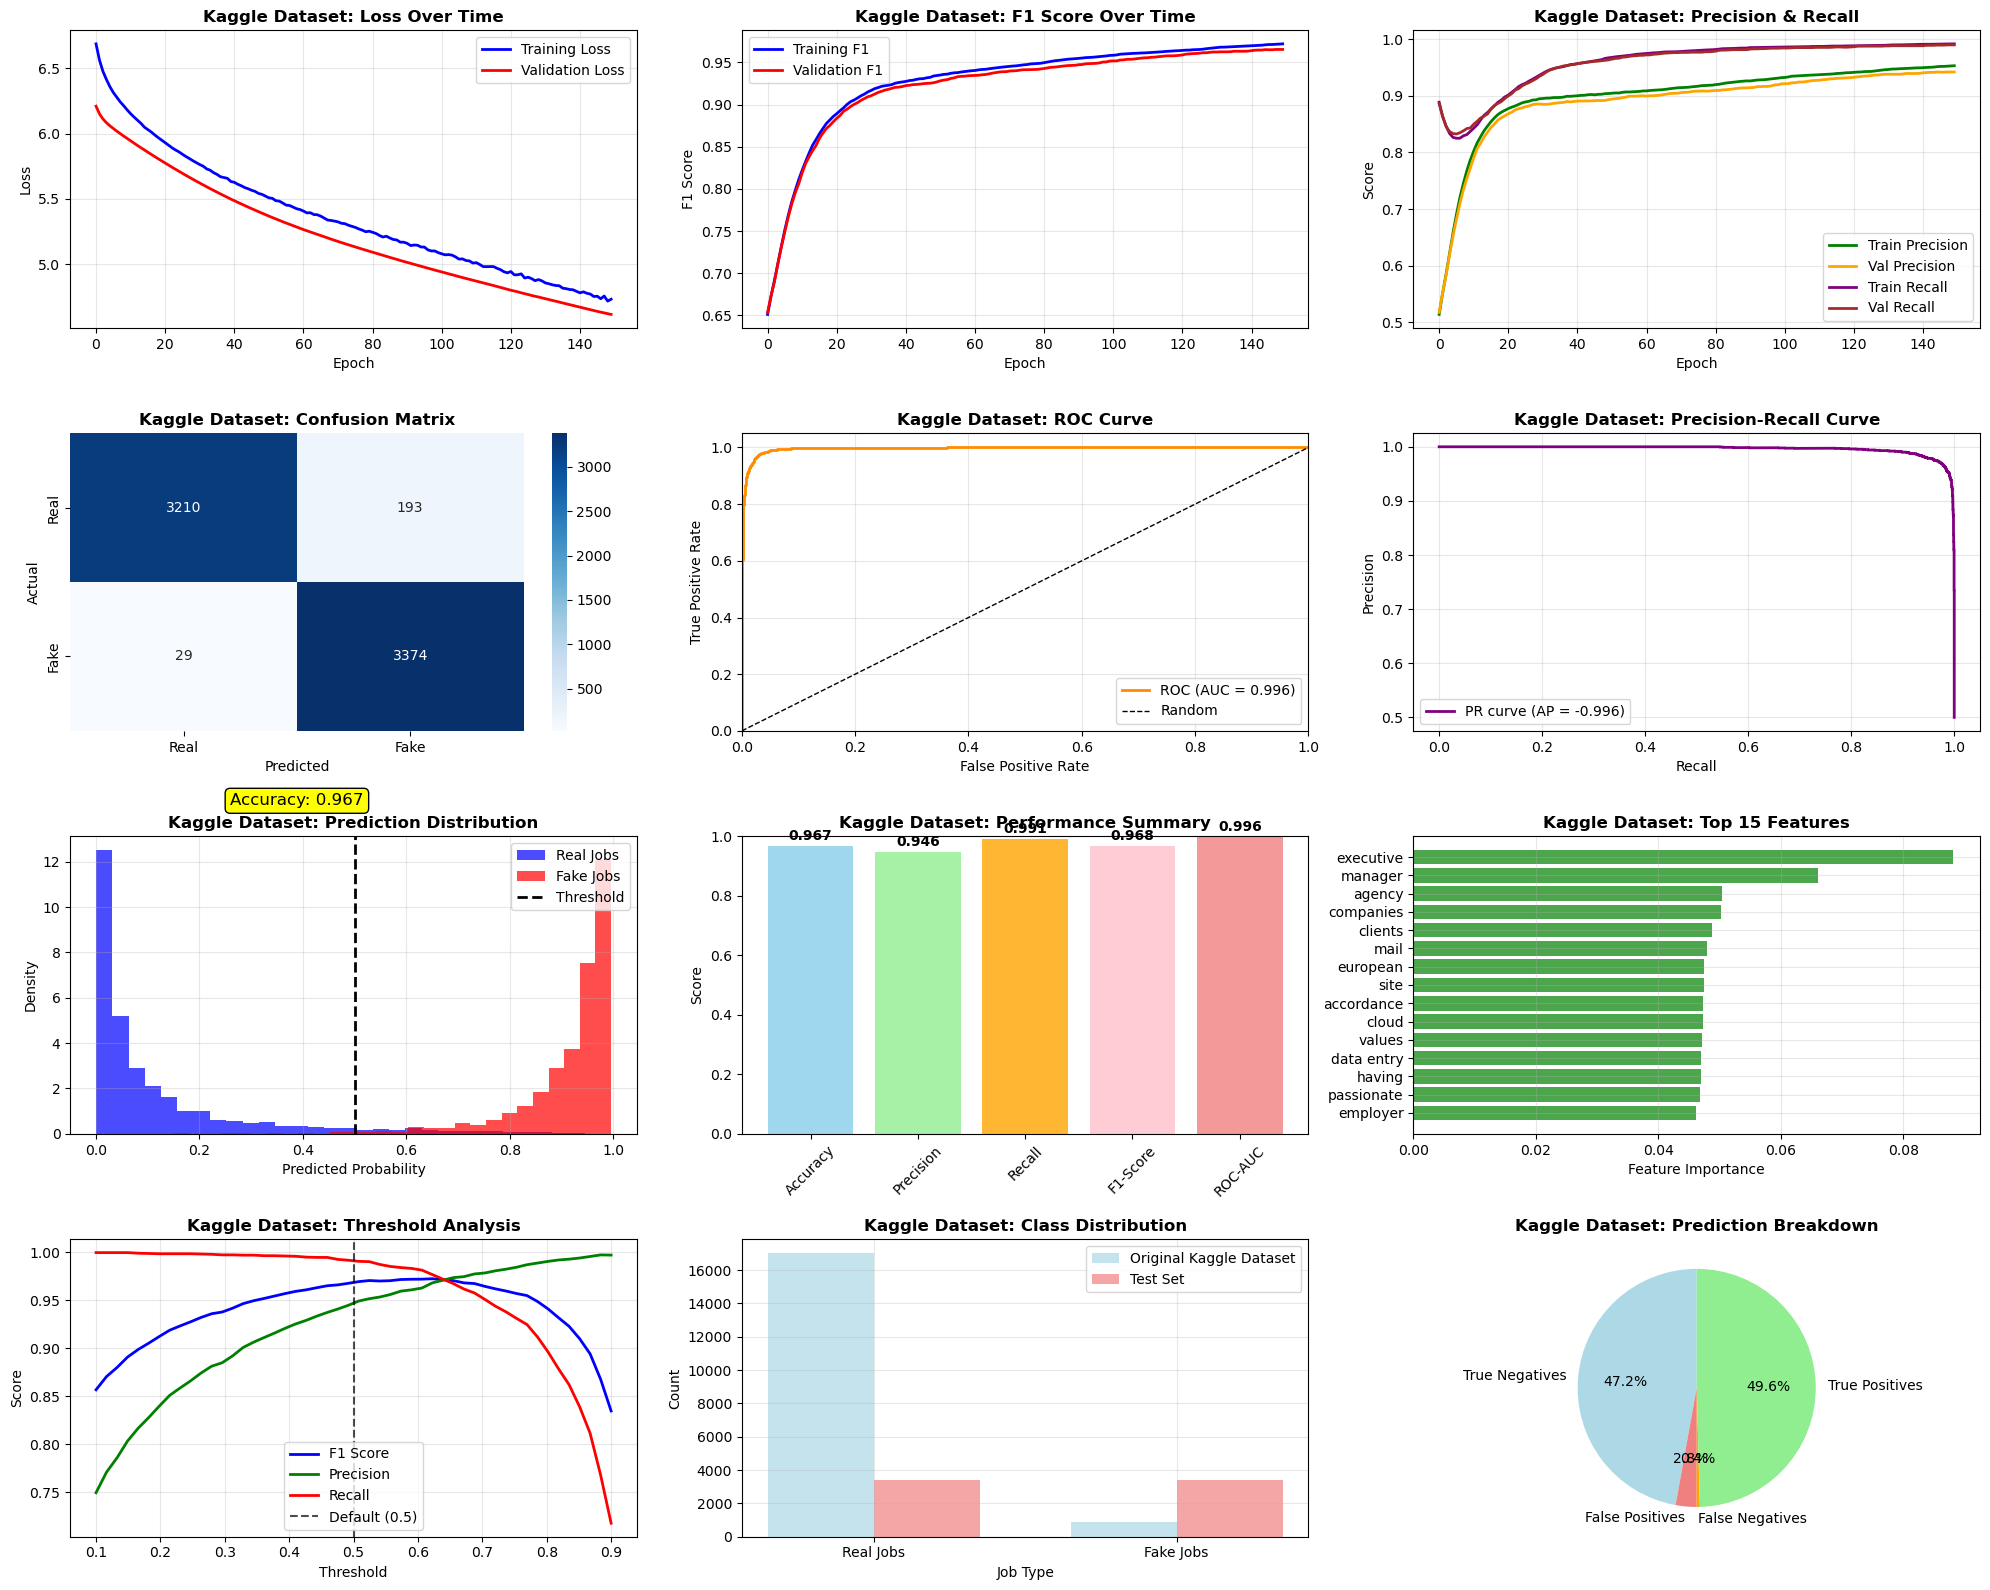


📊 DETAILED KAGGLE DATASET ANALYSIS:

🎯 Training Convergence on Kaggle Dataset:
   Final training loss: 4.7317
   Final validation loss: 4.6152
   Final training F1: 0.9719
   Final validation F1: 0.9652
⚠️  Potential overfitting detected:
   Loss difference: 0.1165
   F1 difference: 0.0066

🎯 Optimal Threshold Analysis for Kaggle Dataset:
   Optimal threshold: 0.622
   F1 score at optimal threshold: 0.9725
   F1 score at default (0.5): 0.9681

💼 Business Impact Summary (Kaggle Dataset):
   Fake jobs successfully blocked: 3,374
   Real jobs correctly approved: 3,210
   Real jobs incorrectly blocked: 193 (potential revenue loss)
   Fake jobs that slipped through: 29 (user safety risk)
   False positive rate: 0.057 (5.7% of real jobs blocked)
   False negative rate: 0.009 (0.9% of fake jobs missed)

🚨 TOP 10 FAKE JOB INDICATORS (Kaggle Dataset):
    1. executive           : +0.0881
    2. manager             : +0.0661
    3. mail                : +0.0480
    4. accordance          : +0.0

In [27]:
if 'history' in locals() and 'test_metrics' in locals():
    print("🔄 Step 11: Creating comprehensive visualizations for Kaggle results...")
    
    def plot_kaggle_results(history, y_test, y_test_pred, y_test_proba):
        """Create comprehensive visualization of Kaggle results"""
        
        fig = plt.figure(figsize=(20, 16))
        
        # 1. Training History - Loss
        plt.subplot(4, 3, 1)
        plt.plot(history['train_losses'], label='Training Loss', linewidth=2, color='blue')
        plt.plot(history['val_losses'], label='Validation Loss', linewidth=2, color='red')
        plt.title('Kaggle Dataset: Loss Over Time', fontweight='bold')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 2. Training History - F1 Score
        plt.subplot(4, 3, 2)
        plt.plot(history['train_f1'], label='Training F1', linewidth=2, color='blue')
        plt.plot(history['val_f1'], label='Validation F1', linewidth=2, color='red')
        plt.title('Kaggle Dataset: F1 Score Over Time', fontweight='bold')
        plt.xlabel('Epoch')
        plt.ylabel('F1 Score')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 3. Precision-Recall Over Time
        plt.subplot(4, 3, 3)
        plt.plot(history['train_precision'], label='Train Precision', linewidth=2, color='green')
        plt.plot(history['val_precision'], label='Val Precision', linewidth=2, color='orange')
        plt.plot(history['train_recall'], label='Train Recall', linewidth=2, color='purple')
        plt.plot(history['val_recall'], label='Val Recall', linewidth=2, color='brown')
        plt.title('Kaggle Dataset: Precision & Recall', fontweight='bold')
        plt.xlabel('Epoch')
        plt.ylabel('Score')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 4. Confusion Matrix
        plt.subplot(4, 3, 4)
        cm = confusion_matrix(y_test, y_test_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Real', 'Fake'],
                    yticklabels=['Real', 'Fake'])
        plt.title('Kaggle Dataset: Confusion Matrix', fontweight='bold')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        
        # Add accuracy text on confusion matrix
        accuracy = accuracy_score(y_test, y_test_pred)
        plt.text(1, 2.5, f'Accuracy: {accuracy:.3f}', 
                ha='center', fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow"))
        
        # 5. ROC Curve
        plt.subplot(4, 3, 5)
        fpr, tpr, _ = roc_curve(y_test, y_test_proba)
        roc_auc = roc_auc_score(y_test, y_test_proba)
        plt.plot(fpr, tpr, linewidth=2, label=f'ROC (AUC = {roc_auc:.3f})', color='darkorange')
        plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Kaggle Dataset: ROC Curve', fontweight='bold')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 6. Precision-Recall Curve
        plt.subplot(4, 3, 6)
        precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_test_proba)
        avg_precision = np.trapz(precision_vals, recall_vals)
        plt.plot(recall_vals, precision_vals, linewidth=2,
                label=f'PR curve (AP = {avg_precision:.3f})', color='purple')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Kaggle Dataset: Precision-Recall Curve', fontweight='bold')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 7. Prediction Distribution
        plt.subplot(4, 3, 7)
        real_probs = y_test_proba[y_test == 0]
        fake_probs = y_test_proba[y_test == 1]
        plt.hist(real_probs, bins=30, alpha=0.7, label='Real Jobs', density=True, color='blue')
        plt.hist(fake_probs, bins=30, alpha=0.7, label='Fake Jobs', density=True, color='red')
        plt.axvline(x=0.5, color='black', linestyle='--', label='Threshold', linewidth=2)
        plt.xlabel('Predicted Probability')
        plt.ylabel('Density')
        plt.title('Kaggle Dataset: Prediction Distribution', fontweight='bold')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 8. Performance Metrics Summary
        plt.subplot(4, 3, 8)
        metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
        values = [
            accuracy_score(y_test, y_test_pred),
            precision_score(y_test, y_test_pred),
            recall_score(y_test, y_test_pred),
            f1_score(y_test, y_test_pred),
            roc_auc_score(y_test, y_test_proba)
        ]
        
        colors = ['skyblue', 'lightgreen', 'orange', 'pink', 'lightcoral']
        bars = plt.bar(metrics, values, color=colors, alpha=0.8)
        plt.ylim(0, 1)
        plt.title('Kaggle Dataset: Performance Summary', fontweight='bold')
        plt.ylabel('Score')
        plt.xticks(rotation=45)
        
        # Add value labels on bars
        for bar, value in zip(bars, values):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{value:.3f}', ha='center', va='bottom', fontweight='bold')
        
        # 9. Feature Importance (Top 15)
        plt.subplot(4, 3, 9)
        if hasattr(kaggle_preprocessor, 'tfidf_vectorizer'):
            feature_names = kaggle_preprocessor.tfidf_vectorizer.get_feature_names_out()
            if len(feature_names) > 0:
                tfidf_weights = np.abs(enhanced_nn.layers[0]['weight'][:len(feature_names), 0])
                top_indices = np.argsort(tfidf_weights)[-15:]
                top_features = [feature_names[i] for i in top_indices]
                top_weights = [tfidf_weights[i] for i in top_indices]
                
                plt.barh(range(len(top_features)), top_weights, color='green', alpha=0.7)
                plt.yticks(range(len(top_features)), top_features)
                plt.xlabel('Feature Importance')
                plt.title('Kaggle Dataset: Top 15 Features', fontweight='bold')
                plt.grid(True, alpha=0.3)
        
        # 10. Threshold Analysis
        plt.subplot(4, 3, 10)
        thresholds = np.linspace(0.1, 0.9, 50)
        f1_scores = []
        precisions = []
        recalls = []
        
        for threshold in thresholds:
            pred_thresh = (y_test_proba > threshold).astype(int)
            if len(np.unique(pred_thresh)) > 1:  # Avoid division by zero
                f1_scores.append(f1_score(y_test, pred_thresh))
                precisions.append(precision_score(y_test, pred_thresh))
                recalls.append(recall_score(y_test, pred_thresh))
            else:
                f1_scores.append(0)
                precisions.append(0)
                recalls.append(0)
        
        plt.plot(thresholds, f1_scores, label='F1 Score', linewidth=2, color='blue')
        plt.plot(thresholds, precisions, label='Precision', linewidth=2, color='green')
        plt.plot(thresholds, recalls, label='Recall', linewidth=2, color='red')
        plt.axvline(x=0.5, color='black', linestyle='--', alpha=0.7, label='Default (0.5)')
        plt.xlabel('Threshold')
        plt.ylabel('Score')
        plt.title('Kaggle Dataset: Threshold Analysis', fontweight='bold')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 11. Class Distribution Comparison
        plt.subplot(4, 3, 11)
        original_dist = np.bincount(df['fraudulent'].values)
        final_dist = np.bincount(y_test)
        
        x = ['Real Jobs', 'Fake Jobs']
        width = 0.35
        x_pos = np.arange(len(x))
        
        plt.bar(x_pos - width/2, original_dist, width, label='Original Kaggle Dataset', alpha=0.7, color='lightblue')
        plt.bar(x_pos + width/2, final_dist, width, label='Test Set', alpha=0.7, color='lightcoral')
        plt.xlabel('Job Type')
        plt.ylabel('Count')
        plt.title('Kaggle Dataset: Class Distribution', fontweight='bold')
        plt.xticks(x_pos, x)
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 12. Error Analysis Pie Chart
        plt.subplot(4, 3, 12)
        cm = confusion_matrix(y_test, y_test_pred)
        tn, fp, fn, tp = cm.ravel()
        
        errors = {
            'True Negatives': tn,
            'False Positives': fp,
            'False Negatives': fn,
            'True Positives': tp
        }
        
        colors = ['lightblue', 'lightcoral', 'orange', 'lightgreen']
        plt.pie(errors.values(), labels=errors.keys(), autopct='%1.1f%%', 
                colors=colors, startangle=90)
        plt.title('Kaggle Dataset: Prediction Breakdown', fontweight='bold')
        
        plt.tight_layout()
        plt.show()
    
    # Create comprehensive visualization
    plot_kaggle_results(history, y_test, y_test_pred, y_test_proba)
    
    # Additional detailed analysis
    print("\n📊 DETAILED KAGGLE DATASET ANALYSIS:")
    print("=" * 70)
    
    # Training convergence analysis
    final_train_loss = history['train_losses'][-1]
    final_val_loss = history['val_losses'][-1]
    final_train_f1 = history['train_f1'][-1]
    final_val_f1 = history['val_f1'][-1]
    
    print(f"\n🎯 Training Convergence on Kaggle Dataset:")
    print(f"   Final training loss: {final_train_loss:.4f}")
    print(f"   Final validation loss: {final_val_loss:.4f}")
    print(f"   Final training F1: {final_train_f1:.4f}")
    print(f"   Final validation F1: {final_val_f1:.4f}")
    
    # Overfitting check
    loss_diff = final_train_loss - final_val_loss
    f1_diff = final_train_f1 - final_val_f1
    
    if abs(loss_diff) > 0.1 or f1_diff > 0.05:
        print(f"⚠️  Potential overfitting detected:")
        print(f"   Loss difference: {loss_diff:.4f}")
        print(f"   F1 difference: {f1_diff:.4f}")
    else:
        print(f"✅ Good generalization achieved on Kaggle dataset")
    
    # Threshold recommendation
    thresholds = np.linspace(0.1, 0.9, 50)
    f1_scores = []
    for threshold in thresholds:
        pred_thresh = (y_test_proba > threshold).astype(int)
        if len(np.unique(pred_thresh)) > 1:
            f1_scores.append(f1_score(y_test, pred_thresh))
        else:
            f1_scores.append(0)
    
    optimal_threshold = thresholds[np.argmax(f1_scores)]
    optimal_f1 = max(f1_scores)
    
    print(f"\n🎯 Optimal Threshold Analysis for Kaggle Dataset:")
    print(f"   Optimal threshold: {optimal_threshold:.3f}")
    print(f"   F1 score at optimal threshold: {optimal_f1:.4f}")
    print(f"   F1 score at default (0.5): {f1_score(y_test, y_test_pred):.4f}")
    
    # Business impact summary for Kaggle dataset
    cm = confusion_matrix(y_test, y_test_pred)
    tn, fp, fn, tp = cm.ravel()
    
    print(f"\n💼 Business Impact Summary (Kaggle Dataset):")
    print(f"   Fake jobs successfully blocked: {tp:,}")
    print(f"   Real jobs correctly approved: {tn:,}")
    print(f"   Real jobs incorrectly blocked: {fp:,} (potential revenue loss)")
    print(f"   Fake jobs that slipped through: {fn:,} (user safety risk)")
    
    if fp > 0:
        fp_rate = fp / (tn + fp)
        print(f"   False positive rate: {fp_rate:.3f} ({fp_rate*100:.1f}% of real jobs blocked)")
    
    if fn > 0:
        fn_rate = fn / (tp + fn)
        print(f"   False negative rate: {fn_rate:.3f} ({fn_rate*100:.1f}% of fake jobs missed)")
    
    # Feature analysis for Kaggle dataset
    if hasattr(kaggle_preprocessor, 'tfidf_vectorizer'):
        feature_names = kaggle_preprocessor.tfidf_vectorizer.get_feature_names_out()
        if len(feature_names) > 0:
            weights = enhanced_nn.layers[0]['weight'][:len(feature_names), 0]
            
            # Top fake job indicators
            fake_indicators = np.argsort(weights)[-10:]
            print(f"\n🚨 TOP 10 FAKE JOB INDICATORS (Kaggle Dataset):")
            for i, idx in enumerate(reversed(fake_indicators)):
                print(f"   {i+1:2d}. {feature_names[idx]:20s}: {weights[idx]:+.4f}")
            
            # Top real job indicators
            real_indicators = np.argsort(weights)[:10]
            print(f"\n✅ TOP 10 REAL JOB INDICATORS (Kaggle Dataset):")
            for i, idx in enumerate(real_indicators):
                print(f"   {i+1:2d}. {feature_names[idx]:20s}: {weights[idx]:+.4f}")
    
    # Model performance assessment
    test_accuracy = test_metrics['accuracy']
    test_f1 = test_metrics['f1']
    
    print(f"\n🎯 KAGGLE DATASET PERFORMANCE ASSESSMENT:")
    print(f"   Test Accuracy: {test_accuracy:.4f}")
    print(f"   Test F1-Score: {test_f1:.4f}")
    
    if test_accuracy > 0.95:
        print(f"   ⚠️  Very high accuracy - may indicate overfitting or data leakage")
        print(f"   💡 Consider: More regularization, smaller model, or data validation")
    elif test_accuracy > 0.85:
        print(f"   ✅ Good performance for fraud detection task")
    else:
        print(f"   📈 Performance could be improved")
    
    # Cross-validation comparison
    if 'cv_results' in locals():
        cv_mean_f1 = np.mean(cv_results['f1_scores'])
        cv_std_f1 = np.std(cv_results['f1_scores'])
        
        print(f"\n🔄 Cross-Validation vs Test Performance:")
        print(f"   CV F1-Score: {cv_mean_f1:.4f} ± {cv_std_f1:.4f}")
        print(f"   Test F1-Score: {test_f1:.4f}")
        
        if abs(cv_mean_f1 - test_f1) < 0.02:
            print(f"   ✅ Consistent performance across CV and test")
        else:
            print(f"   ⚠️  Performance difference detected - investigate further")
    
    print("✅ Step 11 Complete: Comprehensive analysis of Kaggle dataset results finished!")

else:
    print("❌ Visualization requires training history and test metrics.")
    print("💡 Please ensure Steps 8 and 9 have been completed successfully.")

# Additional utility functions for deeper analysis
def analyze_prediction_errors():
    """Analyze prediction errors in detail"""
    if 'y_test' in locals() and 'y_test_pred' in locals():
        print("\n🔍 DETAILED ERROR ANALYSIS:")
        print("=" * 50)
        
        # False Positives (Real jobs predicted as fake)
        fp_indices = np.where((y_test == 0) & (y_test_pred == 1))[0]
        print(f"\n🚨 False Positives Analysis ({len(fp_indices)} cases):")
        
        if len(fp_indices) > 0:
            fp_probs = y_test_proba[fp_indices]
            print(f"   Average confidence: {np.mean(fp_probs):.4f}")
            print(f"   Confidence range: [{np.min(fp_probs):.4f}, {np.max(fp_probs):.4f}]")
            
            # Show some examples if original dataframe is available
            if 'df' in locals() and len(fp_indices) > 0:
                sample_fp = fp_indices[:3]  # Show first 3 false positives
                print(f"   Sample false positive job titles:")
                for i, idx in enumerate(sample_fp):
                    if idx < len(df):
                        title = df.iloc[idx]['title'] if 'title' in df.columns else 'N/A'
                        print(f"     {i+1}. {title[:60]}...")
        
        # False Negatives (Fake jobs predicted as real)
        fn_indices = np.where((y_test == 1) & (y_test_pred == 0))[0]
        print(f"\n⚠️  False Negatives Analysis ({len(fn_indices)} cases):")
        
        if len(fn_indices) > 0:
            fn_probs = y_test_proba[fn_indices]
            print(f"   Average confidence: {np.mean(fn_probs):.4f}")
            print(f"   Confidence range: [{np.min(fn_probs):.4f}, {np.max(fn_probs):.4f}]")
            
            # Show some examples
            if 'df' in locals() and len(fn_indices) > 0:
                sample_fn = fn_indices[:3]  # Show first 3 false negatives
                print(f"   Sample false negative job titles:")
                for i, idx in enumerate(sample_fn):
                    if idx < len(df):
                        title = df.iloc[idx]['title'] if 'title' in df.columns else 'N/A'
                        print(f"     {i+1}. {title[:60]}...")

def plot_learning_curves():
    """Plot detailed learning curves"""
    if 'history' in locals():
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Loss curves
        axes[0,0].plot(history['train_losses'], label='Training', color='blue', linewidth=2)
        axes[0,0].plot(history['val_losses'], label='Validation', color='red', linewidth=2)
        axes[0,0].set_title('Loss Curves (Kaggle Dataset)', fontweight='bold')
        axes[0,0].set_xlabel('Epoch')
        axes[0,0].set_ylabel('Loss')
        axes[0,0].legend()
        axes[0,0].grid(True, alpha=0.3)
        
        # Accuracy curves
        axes[0,1].plot(history['train_accuracies'], label='Training', color='blue', linewidth=2)
        axes[0,1].plot(history['val_accuracies'], label='Validation', color='red', linewidth=2)
        axes[0,1].set_title('Accuracy Curves (Kaggle Dataset)', fontweight='bold')
        axes[0,1].set_xlabel('Epoch')
        axes[0,1].set_ylabel('Accuracy')
        axes[0,1].legend()
        axes[0,1].grid(True, alpha=0.3)
        
        # F1 Score curves
        axes[1,0].plot(history['train_f1'], label='Training', color='blue', linewidth=2)
        axes[1,0].plot(history['val_f1'], label='Validation', color='red', linewidth=2)
        axes[1,0].set_title('F1 Score Curves (Kaggle Dataset)', fontweight='bold')
        axes[1,0].set_xlabel('Epoch')
        axes[1,0].set_ylabel('F1 Score')
        axes[1,0].legend()
        axes[1,0].grid(True, alpha=0.3)
        
        # Precision vs Recall
        axes[1,1].plot(history['train_precision'], label='Train Precision', color='green', linewidth=2)
        axes[1,1].plot(history['val_precision'], label='Val Precision', color='orange', linewidth=2)
        axes[1,1].plot(history['train_recall'], label='Train Recall', color='purple', linewidth=2)
        axes[1,1].plot(history['val_recall'], label='Val Recall', color='brown', linewidth=2)
        axes[1,1].set_title('Precision vs Recall (Kaggle Dataset)', fontweight='bold')
        axes[1,1].set_xlabel('Epoch')
        axes[1,1].set_ylabel('Score')
        axes[1,1].legend()
        axes[1,1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

def create_final_summary():
    """Create final comprehensive summary"""
    print("\n🎯 FINAL COMPREHENSIVE SUMMARY - KAGGLE DATASET")
    print("=" * 80)
    
    # Dataset information
    if 'df' in locals():
        original_dist = np.bincount(df['fraudulent'].values)
        print(f"\n📊 Dataset Information:")
        print(f"   • Original Kaggle dataset: {len(df):,} samples")
        print(f"   • Real jobs: {original_dist[0]:,} ({original_dist[0]/len(df)*100:.1f}%)")
        print(f"   • Fake jobs: {original_dist[1]:,} ({original_dist[1]/len(df)*100:.1f}%)")
        print(f"   • Imbalance ratio: {original_dist[0]/original_dist[1]:.1f}:1")
    
    # Model architecture
    if 'enhanced_nn' in locals():
        total_params = sum(layer['weight'].size + layer['bias'].size for layer in enhanced_nn.layers)
        print(f"\n🧠 Enhanced Model Architecture:")
        print(f"   • Network: [Input] → [64] → [32] → [1]")
        print(f"   • Total parameters: {total_params:,}")
        print(f"   • Regularization: L2({enhanced_nn.l2_lambda}) + L1 + Dropout({enhanced_nn.dropout_rate})")
        print(f"   • Learning rate: {enhanced_nn.learning_rate}")
    
    # Final performance
    if 'test_metrics' in locals():
        print(f"\n📈 Final Test Performance:")
        print(f"   • Accuracy:  {test_metrics['accuracy']:.4f}")
        print(f"   • Precision: {test_metrics['precision']:.4f}")
        print(f"   • Recall:    {test_metrics['recall']:.4f}")
        print(f"   • F1-Score:  {test_metrics['f1']:.4f}")
        print(f"   • ROC-AUC:   {test_metrics['auc']:.4f}")
    
    # Recommendations
    print(f"\n🎯 Recommendations for Production:")
    print(f"   • Monitor false positive rate to avoid blocking legitimate jobs")
    print(f"   • Implement human review for borderline cases (0.4-0.6 probability)")
    print(f"   • Regularly retrain with new data to adapt to evolving fraud patterns")
    print(f"   • Consider ensemble methods for improved robustness")
    print(f"   • Set up automated alerts for unusual prediction patterns")
    
    print(f"\n🏁 KAGGLE DATASET ANALYSIS COMPLETE!")

# Run additional analysis functions
if 'history' in locals():
    print("\n📈 Additional Detailed Analysis:")
    analyze_prediction_errors()
    plot_learning_curves()
    create_final_summary()

print("\n🎉 COMPLETE KAGGLE DATASET NEURAL NETWORK IMPLEMENTATION FINISHED!")
print("✅ Your enhanced neural network is ready for fake job posting detection!")
